In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import *
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Set two decimal points for display
pd.options.display.float_format = "{:.2f}".format

# Load the Data

In [4]:
armada= pd.read_csv("C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/May 2020 Interim Analysis Data for Manuscripts/ARMADA_TBSCORES_MAY2020.csv")
armada.shape

(1083, 189)

In [5]:
armada.assmnt.value_counts()

1    817
2    266
Name: assmnt, dtype: int64

In [6]:
pain = []
for col in armada.columns:
    if 'Pain' in col:
        pain.append(col)

In [7]:
armada.groupby('cohort2')[pain].count().unstack().reset_index().pivot(index='level_0', columns='cohort2', values=0).to_csv('C:/Users/tsb7592/Downloads/pain.csv')

In [8]:
#Data saved in csv/excel
import glob, os

data_dir= "C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/Mar 2021 UDS data (deidentified)"
os.chdir(data_dir)

In [9]:
uds= pd.read_csv("ARMADA_UDS_MAR21_DI.CSV")
uds.shape

(1046, 618)

In [25]:
import sys 

stdoutOrigin=sys.stdout 
sys.stdout = open("C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/stat_output.txt", "w")

In [10]:
cohort ={1:"Gen population healthy aging 85+", 2:"Gen population 65-85", 3:"Gen population MCI",
4:"Gen population AD", 5:"African American mild cognitive impairment",
6:"African American normal controls 65-85", 7:"Spanish Speaking mild cognitive impairment",
8:"Spanish Speaking normal controls 65-85", 9:"Spanish Speaking AD"}

In [11]:
#Rename the value under column cohort2
armada['cohort2'] = armada['cohort2'].map(cohort)

In [12]:
#filter by assmnt = 1
armada = armada[armada.assmnt==1]

# Post Hoc

In [20]:
uds.CDRGLOB.value_counts()

0.00    602
0.50    325
1.00     53
2.00      8
3.00      1
Name: CDRGLOB, dtype: int64

In [22]:
uds.NACCGDS.value_counts().drop(labels=[-4, 8, 9])

88    465
0     231
1     153
2      71
3      38
4      26
5      11
7       9
6       4
10      2
11      1
13      1
Name: NACCGDS, dtype: int64

In [24]:
uds.INDEPEND.value_counts().drop(labels=[9])

1.00    469
2.00     68
3.00     19
4.00      4
Name: INDEPEND, dtype: int64

In [28]:
uds.NPIQINF.value_counts().drop(labels=[-4])

1    298
3    171
2    108
Name: NPIQINF, dtype: int64

In [30]:
uds.NPIQINFX.value_counts()

friend                     42
Friend                     35
Sibling                    12
Sister                      8
sibling                     7
sister                      6
niece                       6
FRIEND                      4
Friends                     3
Niece                       3
friends                     3
Partner                     3
Brother                     2
brother                     2
significant other           2
Mother                      2
STEP DAUGHTER               1
partners                    1
Neighbor                    1
daughter in law             1
cousins                     1
Driver                      1
cousin                      1
SISTER                      1
girlfriend                  1
SON IN LAW                  1
aunt                        1
partner                     1
Boyfriend                   1
Identical Twin              1
friend (31 years)           1
self-report                 1
1/2 Sibling                 1
Girlfriend

# Data Cleaning

In [30]:
#Combine ARMADA with this UDS left join
df = pd.merge(armada,uds, how="left", on=['ptid','assmnt'])

In [77]:
df.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,RESPHEAR,RESPDIST,RESPINTR,RESPDISN,RESPFATG,RESPEMOT,RESPASST,RESPOTH,RESPOTHX,NACCMOCB
0,1.45635,1,Emory,African American normal controls 65-85,en-US,82,2,1,2,0,...,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00
1,1.46421,1,Emory,Gen population AD,en-US,88,1,1,1,1,...,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00
2,1.46422,1,Emory,Gen population MCI,en-US,88,2,1,1,1,...,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00
3,1.46931,1,Emory,African American normal controls 65-85,en-US,73,2,1,2,0,...,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00
4,1.47476,1,Emory,Gen population MCI,en-US,66,1,1,2,0,...,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00,-4.00


In [79]:
#MEMORY through comport (so total of 9 variables)
keep = ['MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE',
       'CDRSUM', 'CDRGLOB', 'COMPORT']

In [82]:
#Only keep the rows with a valid MINDATEDIFF
df =df[df.MINDATEDIFF.notnull()]

In [83]:
select = [ 'Gen population 65-85', 'Gen population MCI','Gen population AD']
genpop = df[df.cohort2.isin(select)]

In [141]:
genpop.groupby('cohort2')['SEX'].count()

cohort2
Gen population 65-85    157
Gen population AD        69
Gen population MCI       97
Name: SEX, dtype: int64

In [85]:
genpop.cohort2.value_counts()

Gen population 65-85    160
Gen population MCI       97
Gen population AD        69
Name: cohort2, dtype: int64

In [87]:
genpop.to_csv("C:/Users/tsb7592/Downloads/genpop.csv")

In [136]:
def anova_one_var(data, var):
    #Test age
    li =[]
    for cohort in select:
        
        li.append(data[data.cohort2== cohort][var].dropna())

    F, p =f_oneway(li[0], li[1],li[2])
    N = len(li[0]+li[1]+li[2])
    print('degree of freedom',N-3)
    print('F statistic = {:5.2f} and probability p = {:5.2f}'.format(F, p))
    return F,p
    
    

In [137]:
#The one-way ANOVA tests the null hypothesis that 3 genpop groups have the same population mean for age
anova_one_var(genpop, 'AGE')

degree of freedom 323
F statistic = 16.07 and probability p =  0.00


(16.06850265490154, 2.2246667017622777e-07)

# 1) Count for each variable across all 3 gen pop groups 

In [88]:
counts  = genpop.groupby('cohort2')[keep].count().unstack().reset_index().pivot(index='level_0', columns='cohort2', values=0)

In [108]:
counts =counts.reindex(keep)[select]
print(counts)
print("")

cohort2   Gen population 65-85  Gen population MCI  Gen population AD
level_0                                                              
MEMORY                     160                  97                 69
ORIENT                     160                  97                 69
JUDGMENT                   160                  97                 69
COMMUN                     160                  97                 69
HOMEHOBB                   160                  97                 69
PERSCARE                   160                  97                 69
CDRSUM                     160                  93                 69
CDRGLOB                    160                  97                 69
COMPORT                    106                  92                 69



# 2) ANOVA & Tukey’s Test ('CDRSUM', 'CDRGLOB')

https://www.statology.org/tukey-test-python/
http://pytolearn.csd.auth.gr/d1-hyptest/12/anova-one.html

In [109]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#The one-way ANOVA tests the null hypothesis that 3 genpop groups have the same population mean.
print("----one-way ANOVA----")

F, p =f_oneway(genpop['CDRGLOB'].dropna(),genpop['CDRSUM'].dropna())
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 
print("")

----one-way ANOVA----
F statistic = 83.585 and probability p = 0.000



In [94]:
genpop_melt = pd.melt(genpop[keep[6:8]].reset_index(), id_vars=['index'], value_vars=keep[6:8])
# replace column namesg
genpop_melt.columns = ['index', 'col', 'value']

In [95]:
genpop_melt=genpop_melt.dropna()

In [110]:
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=genpop_melt['value'],
                          groups=genpop_melt['col'],
                          alpha=0.05)

#display results
print(tukey)
print('')

Multiple Comparison of Means - Tukey HSD, FWER=0.05
 group1 group2 meandiff p-adj lower  upper  reject
--------------------------------------------------
CDRGLOB CDRSUM   1.0959 0.001 0.8605 1.3313   True
--------------------------------------------------



# 3)  NACCFAM counts per group

In [97]:
df.NACCFAM.value_counts()

9.00    423
1.00    225
0.00    135
Name: NACCFAM, dtype: int64

In [98]:
#Drop the unknown NACCFAM 
Ncounts  = genpop[genpop.NACCFAM !=9 ].groupby('NACCFAM')['cohort2'].value_counts().unstack()
#Ncounts.to_excel('C:/Users/tsb7592/Downloads/NACCFAM.xlsx')

In [111]:
print(Ncounts)

cohort2  Gen population 65-85  Gen population AD  Gen population MCI
NACCFAM                                                             
0.00                       29                 23                  24
1.00                       61                 30                  56


In [112]:
#Chi square results got from R

#Pearson's Chi-squared test
print('X-squared = 2.7786, df = 2, p-value = 0.2493')
print("")

X-squared = 7.7844, df = 2, p-value = 0.0204



# 4) HYPERT counts per group

In [101]:
df.HYPERTEN.unique()

array([ 1., -4.,  0.,  2.,  9.])

In [102]:
df.HYPERCHO.value_counts()

-4.00    303
1.00     242
0.00     225
2.00      12
9.00       1
Name: HYPERCHO, dtype: int64

In [113]:
h1=genpop[(genpop.HYPERTEN != 9 )&(genpop.HYPERTEN !=-4)].groupby('HYPERTEN')['cohort2'].value_counts().unstack().fillna(0)
print(h1)

cohort2   Gen population 65-85  Gen population AD  Gen population MCI
HYPERTEN                                                             
0.00                     54.00              13.00               19.00
1.00                     25.00              15.00               17.00
2.00                      0.00               2.00                1.00


In [115]:
#Pearson's Chi-squared test

print("X-squared = 10.077, df = 4, p-value = 0.03916")
print("")

X-squared = 10.077, df = 4, p-value = 0.03916



In [114]:
h2=genpop[(genpop.HYPERCHO != 9 )&(genpop.HYPERCHO !=-4)].groupby('HYPERCHO')['cohort2'].value_counts().unstack().fillna(0)
print(h2)

cohort2   Gen population 65-85  Gen population AD  Gen population MCI
HYPERCHO                                                             
0.00                     44.00              15.00               15.00
1.00                     35.00              15.00               21.00
2.00                      0.00               0.00                1.00


In [106]:
#Pearson's Chi-squared test

#data:  h2
print("X-squared = 4.9095, df = 4, p-value = 0.2967")


In [107]:
sys.stdout.close()
sys.stdout=stdoutOrigin

# Armada Pain
For each of the four Odor variables:
Compare them by cohort (so there should be nine in total)

In [56]:
Odor =[]
for val in armada.columns:
    if 'Odor' in val:
        Odor.append(val)
    if 'Pain' in val:
        print(val)

PainInt_Raw
PainInt_SE
PainInt_Theta
PainInt_TScore


In [57]:
armada.cohort2.unique()

array(['African American normal controls 65-85', 'Gen population AD',
       'Gen population MCI', 'African American mild cognitive impairment',
       'Gen population 65-85', 'Gen population healthy aging 85+',
       'Spanish Speaking mild cognitive impairment',
       'Spanish Speaking normal controls 65-85', 'Spanish Speaking AD'],
      dtype=object)

In [58]:
odor = armada.groupby('cohort2')[Odor].count().unstack().reset_index().pivot(index='level_0', columns='cohort2', values=0)
odor

cohort2,African American mild cognitive impairment,African American normal controls 65-85,Gen population 65-85,Gen population AD,Gen population MCI,Gen population healthy aging 85+,Spanish Speaking AD,Spanish Speaking mild cognitive impairment,Spanish Speaking normal controls 65-85
level_0,,,,,,,,,
Odor_ACSScore,34,93,159,61,85,17,21,97,107
Odor_FCTScore,33,93,159,61,85,17,21,97,105
Odor_Raw,35,93,159,67,101,109,23,100,107
Odor_UCSScore,35,93,159,67,101,109,23,100,107


# Histogram (9)
Boxplot (nine boxplots)
Table with Ns, Min, Median, Mean, Max, and SD
One row for all data
Nine rows for each of the cohorts
Table of 10 x 6

In [59]:
#Data saved in csv/excel
import glob, os

data_dir= "C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis"
os.chdir(data_dir)

In [60]:
Odor

['Odor_ACSScore', 'Odor_FCTScore', 'Odor_Raw', 'Odor_UCSScore']

<Figure size 576x432 with 0 Axes>

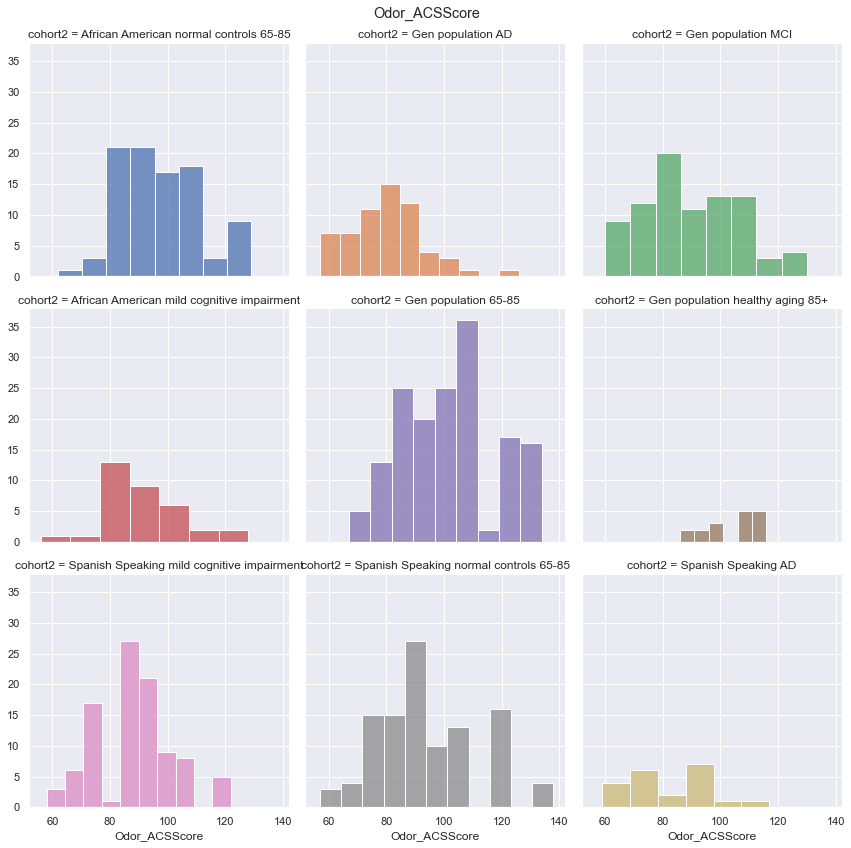

<Figure size 576x432 with 0 Axes>

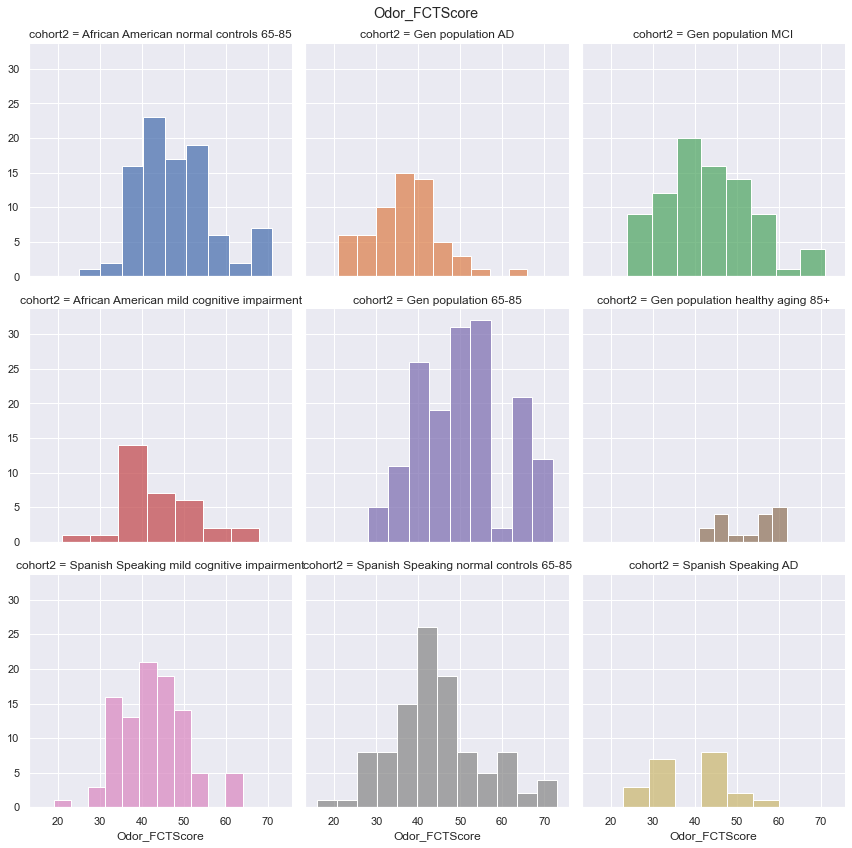

<Figure size 576x432 with 0 Axes>

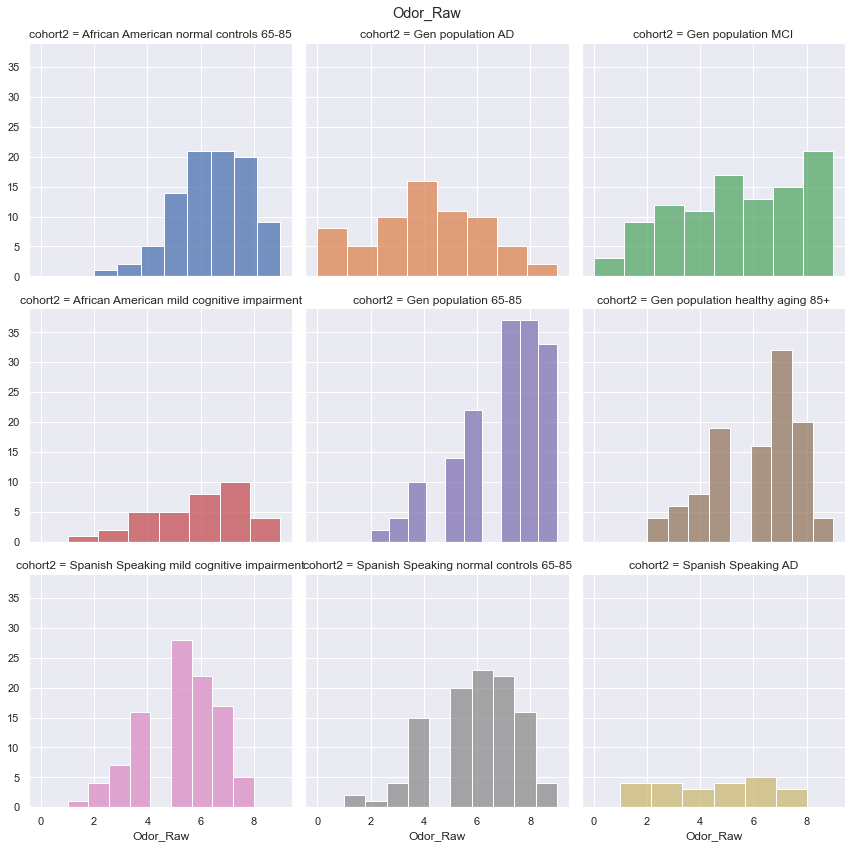

<Figure size 576x432 with 0 Axes>

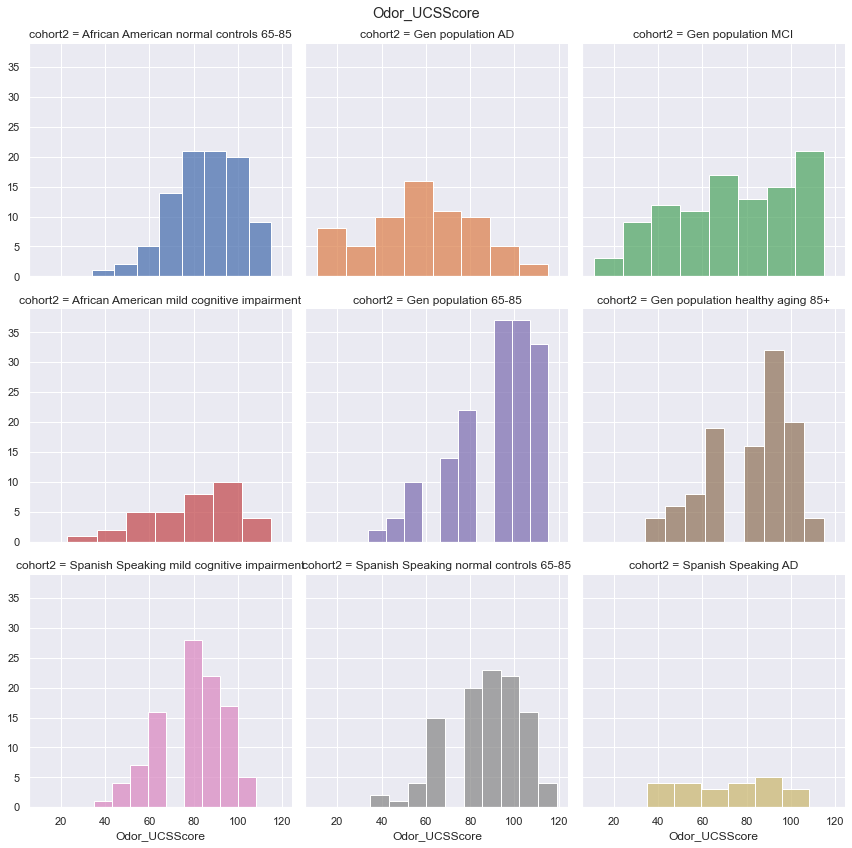

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

for var in Odor:
    sns.set() 
    plt.figure(figsize=(8, 6))
    g = sns.FacetGrid(armada, col="cohort2" ,hue="cohort2",size=4, aspect=1,col_wrap=3)
    g.fig.suptitle(var)
    g.map(sns.histplot, var)
    plt.savefig(str(var)+'_hist.png')

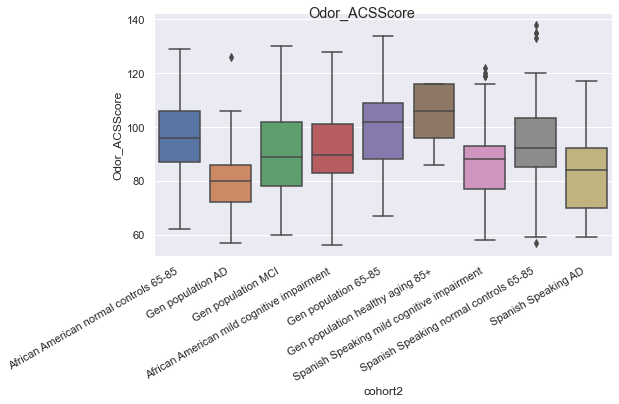

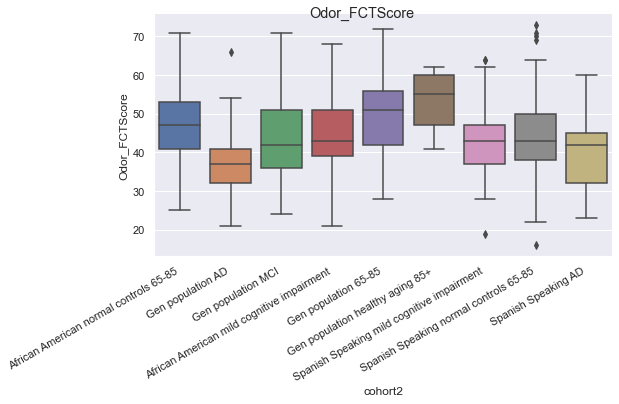

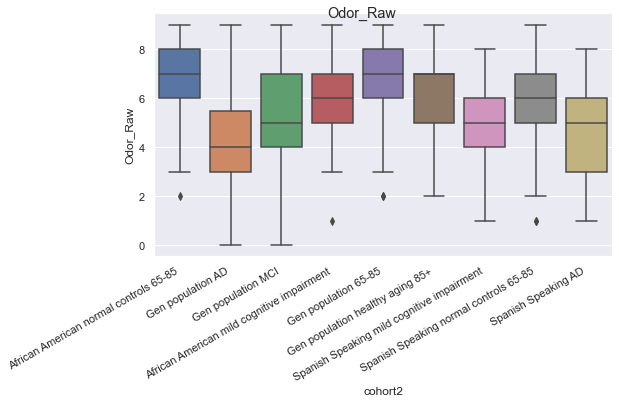

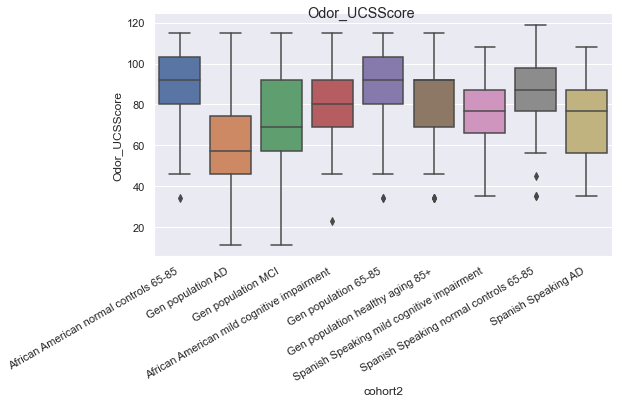

In [62]:
 
for var in Odor:
    g = sns.factorplot('cohort2', var,  data=armada, kind="box",size=4, aspect=2)
    g.fig.suptitle(var)
    
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30, horizontalalignment='right')
    
    plt.savefig(str(var)+'_boxplot.png',bbox_inches='tight')

In [63]:
amelt = pd.melt(armada.reset_index(), id_vars=['index', 'cohort2'], value_vars=Odor)
# replace column namesg
amelt.columns = ['index','cohort2', 'col', 'value']

In [64]:
amelt = amelt.dropna()

In [65]:
ALL =amelt.groupby('cohort2')['value'].describe().iloc[:,[1,2]].round(2)

In [66]:
ALL

,mean,std
cohort2,,
African American mild cognitive impairment,54.85,36.01
African American normal controls 65-85,59.67,37.80
Gen population 65-85,62.75,39.88
Gen population AD,44.30,31.35
Gen population MCI,51.68,36.32
Gen population healthy aging 85+,48.55,40.54
Spanish Speaking AD,48.44,33.53
Spanish Speaking mild cognitive impairment,53.71,34.82
Spanish Speaking normal controls 65-85,57.73,37.92


In [67]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/odor_tables.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
odor.to_excel(writer, sheet_name='by_cohort')

for var in Odor:
    ta =armada.groupby('cohort2')[var].describe().unstack().reset_index().pivot(index='level_0', columns='cohort2', values=0)
    ta= ta.iloc[[3,6,1,5,7,4],:].round(2)
    ta.index =['N', 'min', 'median', 'mean', 'std', 'max']
    ta.to_excel(writer, sheet_name=var)
    display(ta)

ALL.to_excel(writer, sheet_name='all')   
# Close the Pandas Excel writer and output the Excel file.
writer.save()

cohort2,African American mild cognitive impairment,African American normal controls 65-85,Gen population 65-85,Gen population AD,Gen population MCI,Gen population healthy aging 85+,Spanish Speaking AD,Spanish Speaking mild cognitive impairment,Spanish Speaking normal controls 65-85
N,34.00,93.00,159.00,61.00,85.00,17.00,21.00,97.00,107.00
min,56.00,62.00,67.00,57.00,60.00,86.00,59.00,58.00,57.00
median,89.50,96.00,102.00,80.00,89.00,106.00,84.00,88.00,92.00
mean,91.44,97.19,101.63,79.84,89.86,103.06,81.48,88.32,94.09
std,14.56,14.15,16.36,13.34,16.62,10.91,15.14,13.04,16.94
max,128.00,129.00,134.00,126.00,130.00,116.00,117.00,122.00,138.00


cohort2,African American mild cognitive impairment,African American normal controls 65-85,Gen population 65-85,Gen population AD,Gen population MCI,Gen population healthy aging 85+,Spanish Speaking AD,Spanish Speaking mild cognitive impairment,Spanish Speaking normal controls 65-85
N,33.00,93.00,159.00,61.00,85.00,17.00,21.00,97.00,105.00
min,21.00,25.00,28.00,21.00,24.00,41.00,23.00,19.00,16.00
median,43.00,47.00,51.00,37.00,42.00,55.00,42.00,43.00,43.00
mean,44.27,47.98,50.83,36.77,43.40,52.41,38.57,42.59,44.39
std,9.68,9.17,10.56,8.67,11.05,6.97,9.76,8.04,10.85
max,68.00,71.00,72.00,66.00,71.00,62.00,60.00,64.00,73.00


cohort2,African American mild cognitive impairment,African American normal controls 65-85,Gen population 65-85,Gen population AD,Gen population MCI,Gen population healthy aging 85+,Spanish Speaking AD,Spanish Speaking mild cognitive impairment,Spanish Speaking normal controls 65-85
N,35.00,93.00,159.00,67.00,101.00,109.00,23.00,100.00,107.00
min,1.00,2.00,2.00,0.00,0.00,2.00,1.00,1.00,1.00
median,6.00,7.00,7.00,4.00,5.00,7.00,5.00,5.00,6.00
mean,5.83,6.58,6.98,4.15,5.36,6.14,4.48,5.25,5.91
std,1.74,1.54,1.69,1.92,2.19,1.71,2.02,1.51,1.69
max,9.00,9.00,9.00,9.00,9.00,9.00,8.00,8.00,9.00


cohort2,African American mild cognitive impairment,African American normal controls 65-85,Gen population 65-85,Gen population AD,Gen population MCI,Gen population healthy aging 85+,Spanish Speaking AD,Spanish Speaking mild cognitive impairment,Spanish Speaking normal controls 65-85
N,35.00,93.00,159.00,67.00,101.00,109.00,23.00,100.00,107.00
min,23.00,34.00,34.00,11.00,11.00,34.00,35.00,35.00,35.00
median,80.00,92.00,92.00,57.00,69.00,92.00,77.00,77.00,87.00
mean,78.31,86.92,91.56,58.97,72.85,81.86,71.26,79.39,86.26
std,20.04,17.73,19.47,22.12,25.23,19.64,21.11,15.83,17.75
max,115.00,115.00,115.00,115.00,115.00,115.00,108.00,108.00,119.00
